## Correlation and regression analysis

*M. Jemeljanova, R.A. Collenteur (November 2022)*

This notebook is part of the manuscript by Jemeljanova et al. titled "*Modeling hydraulic heads with impulse response functions in different environmental settings*" submitted to Journal of Hydrology: Regional Studies.

## 0. Import python packages

In [1]:
import os
import numpy as np
import pandas as pd

from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

import pastas as ps

from tqdm import tqdm

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.preprocessing import MinMaxScaler

import shap

os.chdir('../') 

palette = sns.diverging_palette(220, 20, as_cmap=True)

ps.set_log_level("ERROR")
ps.show_versions()

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Python version: 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:55:37) 
[Clang 14.0.6 ]
Numpy version: 1.23.5
Scipy version: 1.9.3
Pandas version: 1.5.2
Pastas version: 0.21.0
Matplotlib version: 3.6.2


/opt/anaconda3/envs/stable_pastas/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load environmental controls

In [2]:
environmental_variables = pd.read_csv(os.path.join(os.getcwd(), 'input', 'environmental_variables.csv'),
                                     index_col=1).iloc[:, 1:]

# Define different groups of environmental variables

geological = ['A_thickness', 'Depth_to_GW', 'Screen_Upp', 'Screen_Low', 'Aquifer_Depth', 
              'GW_level_mean', 'Dolomite_m', 'Limestone_m', 'Marl_m', 'Clay_silt_m', 
              'Gravel_m', 'Sand_m', 'Sandstone_siltstone_m', 'Silt_loam_m', 'Peat_m']

land_use = ['Artificial', 'Agricultural', 'Forest', 'Wetlands', 'Water_bodies']

topographic = ['hgthps', 'arbel', 'slp', 'twi', 'cnvx', 'cncv', 'cnvr', 'ctchr']

boundary = ['dist_stream', 'dist_boundary', 'height_ow', 'height_stream',
            'height_boundary', 'height_to_stream', 'height_to_boundary']   

climatic = ['PE_avg', 'P_avg', 'T_avg', 'SI', 'AI', 'meanPcoldest', 'meanPwarmest', 
            'meanPdriest', 'meanPwettest', 'ratioPcoldwarm', 'ratioPdrywett']

environmental_variables.head()

,A_thickness,Depth_to_GW,Screen_Upp,Screen_Low,Aquifer_Depth,GW_level_mean,Dolomite_m,Limestone_m,Marl_m,Sandstone_siltstone_m,...,P_avg,T_avg,SI,AI,meanPcoldest,meanPwarmest,meanPdriest,meanPwettest,ratioPcoldwarm,ratioPdrywett
well,,,,,,,,,,,,,,,,,,,,,
LV|9665,5.8,1.064935,3.1,5.1,5.8,87.415065,0.0,0.0,0.0,0.0,...,736.440011,6.731736,0.258758,1.056794,36.396667,84.126668,36.396667,84.126668,0.432641,0.432641
LV|9667,4.2,0.609184,2.1,4.1,5.0,87.061816,0.0,0.0,0.0,0.0,...,736.500011,6.309868,0.242688,1.069608,40.630001,81.406668,40.630001,81.406668,0.499099,0.499099
LV|9658,20.0,16.463273,21.8,40.0,40.0,71.135727,14.8,0.0,1.7,0.0,...,692.830010,6.765482,0.263617,0.985834,34.093334,80.790001,34.093334,80.790001,0.421999,0.421999
LV|9659,35.2,11.228822,24.8,60.0,60.0,82.542178,30.6,0.0,4.6,0.0,...,736.440011,6.731736,0.258758,1.056794,36.396667,84.126668,36.396667,84.126668,0.432641,0.432641
LV|6,50.0,7.012405,120.5,125.0,125.0,3.709595,0.0,0.0,0.0,60.0,...,664.330010,7.434715,0.261547,1.020263,32.503334,79.860001,32.503334,79.860001,0.407004,0.407004


## 2. Visual check of environmental controls

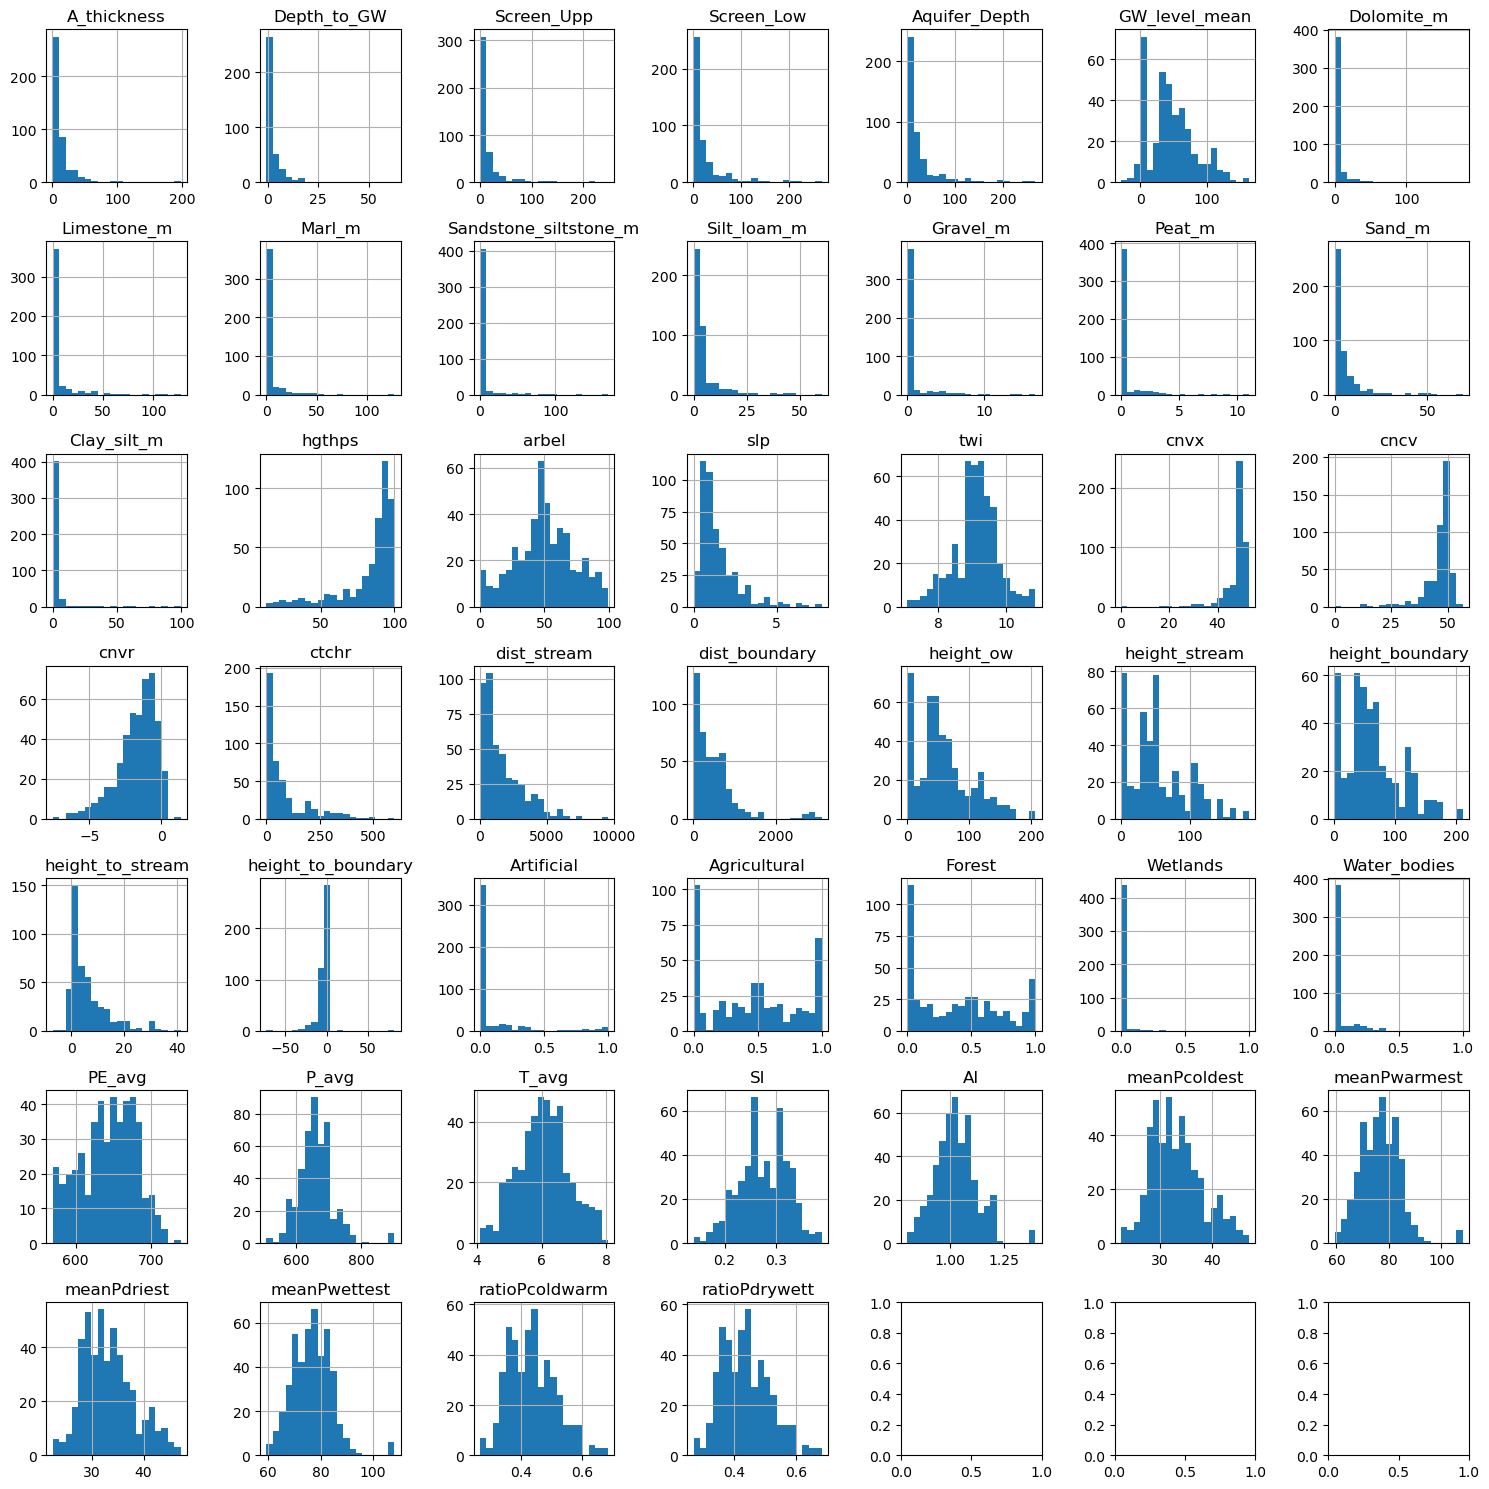

In [3]:
fig, axes = plt.subplots(7, 7, figsize = (15, 15), constrained_layout=True, dpi=100)
environmental_variables.hist(bins=20, ax=axes.flatten()[:46])
plt.tight_layout()

## 2. Descriptor intercorrelations within a group

In [4]:
def plot_correlations(df, plot_type):
    """
    """
    rho = df.corr(method = 'spearman')
    pval = df.corr(method=lambda x, y: spearmanr(x, y)[1]) - np.eye(*rho.shape)
    p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
    values = rho.applymap(lambda x: round(x, 2)).astype(str).add(p, fill_value = '')
    
    if plot_type == 'group':
        fig, ax = plt.subplots(figsize = (20, 20))            
        heatmap = sns.heatmap(rho, mask = np.triu(np.ones_like(rho)), annot = values, 
                              annot_kws={"size": 11, },  cmap = palette, center = 0,  fmt='')
    
    elif plot_type == 'all':
        fig, ax = plt.subplots(figsize = (30, 30))                
        heatmap = sns.heatmap(rho, mask = np.triu(np.ones_like(rho)), annot = values,  
                              annot_kws={"size":9}, cmap = palette, center = 0,  fmt='')

    cbar = heatmap.collections[0].colorbar
    cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation=90, va='center')
    plt.tight_layout()

In [5]:
# for descriptor_group in [geological, topographic, boundary, land_use, climatic]:
#      plot_correlations(environmental_variables.loc[:, descriptor_group], "group")

FixedFormatter should only be used together with FixedLocator


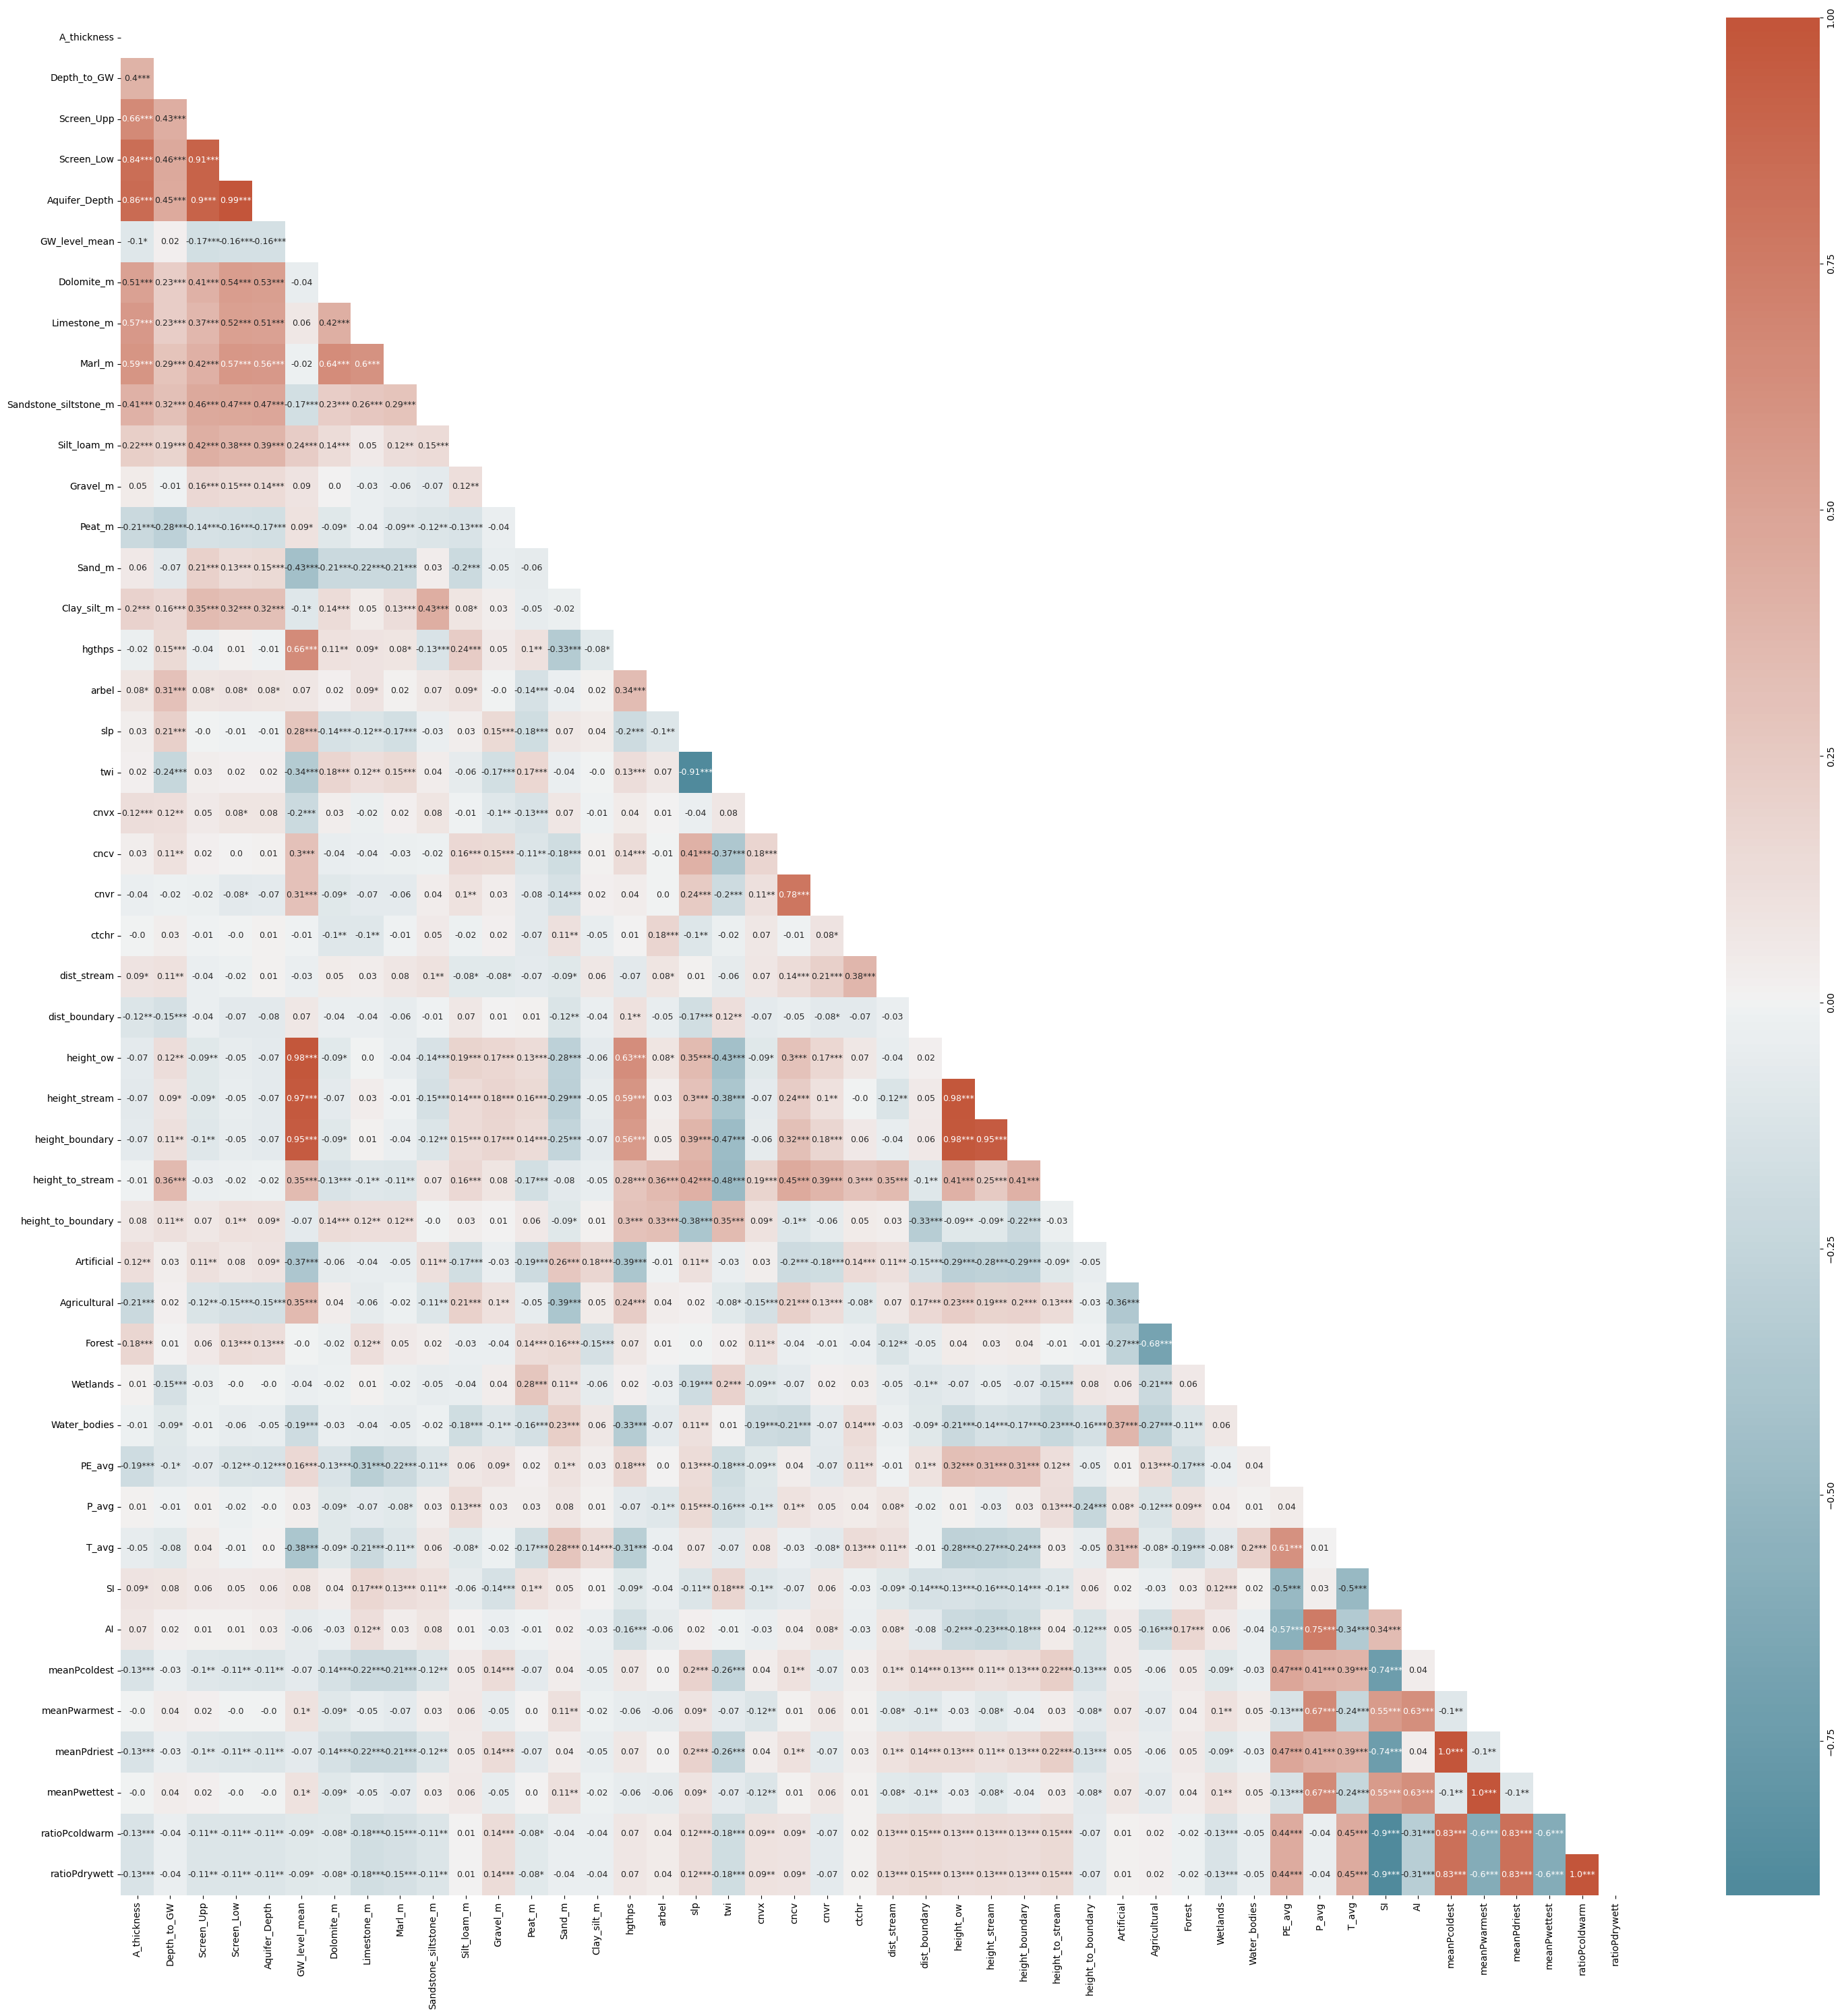

In [6]:
# check correlations for ALL groups
plot_correlations(environmental_variables, 'all')

## Drop some columns that have high correlations among environmental variables

In [7]:
# Detect high correlations for possible exclusion
rho = environmental_variables.corr(method = 'spearman')
rho.index[rho[rho - np.eye(*rho.shape) > 0.9].any()]

Index(['Screen_Upp', 'Screen_Low', 'Aquifer_Depth', 'GW_level_mean',
       'height_ow', 'height_stream', 'height_boundary', 'meanPcoldest',
       'meanPwarmest', 'meanPdriest', 'meanPwettest', 'ratioPcoldwarm',
       'ratioPdrywett'],
      dtype='object')

In [8]:
# Dropping the parameters with correlation > 0.9 or due to other reasons (specified in the article) 
to_remove = ['Aquifer_Depth', 'Screen_Low', 'height_stream', 'height_boundary', 'GW_level_mean',
             'ratioPdrywett', 'ratioPcoldwarm', 'meanPcoldest', 'meanPwarmest', 'slp']

environmental_variables.drop(to_remove, axis = 1, inplace = True)

## 3. Load the goodness-of-fit metrics

In [9]:
metrics = pd.read_csv(os.path.join(os.getcwd(), 'output', 'metrics.csv' ), index_col=[0,1])
metrics.head()

RMSE_c     NSE_c     KGE_c    RMSE_v     NSE_v     KGE_v
LV|9665 LG   0.485406  0.291526  0.358307  0.452322  0.466269  0.468474
        L4   0.382597  0.559853  0.698245  0.600052  0.060701  0.606993
        NLG  0.372915  0.581849  0.633120  0.432140  0.512836  0.706489
        NLS  0.393897  0.533471  0.483766  0.427166  0.523986  0.640590
LV|9667 LG   0.181684  0.722228  0.747378  0.219426  0.644504  0.761891

## 4. Compute correlations between fit and environmental variables

In [10]:
structures = ['LG', 'L4', 'NLG', 'NLS']

correlations = {}
significance = {}

for structure in structures:
    df = metrics.loc[(slice(None), structure), "NSE_c"]
    df.index = df.index.droplevel(1)

    rho = environmental_variables.corrwith(df, method="spearman")
    pval = environmental_variables.corrwith(df, method=lambda x, y: spearmanr(x, y)[1]) #- np.eye(*rho.shape)

    correlations[structure] = rho
    significance[structure] = pval
    
correlations = pd.concat(correlations, axis=1)
significance = pd.concat(significance, axis=1)

correlations.head()

,LG,L4,NLG,NLS
A_thickness,-0.141928,-0.134349,-0.085836,-0.035356
Depth_to_GW,-0.153698,-0.247320,-0.157993,-0.100141
Screen_Upp,-0.115740,-0.121102,-0.056688,-0.023262
Dolomite_m,-0.042244,-0.045711,-0.037426,0.043736
Limestone_m,-0.082113,-0.065627,-0.067445,0.003344


In [11]:
significance.head()

,LG,L4,NLG,NLS
A_thickness,0.002879,0.004807,0.072390,0.459964
Depth_to_GW,0.003117,0.000002,0.002369,0.054943
Screen_Upp,0.014682,0.010650,0.233228,0.624955
Dolomite_m,0.377242,0.339319,0.434098,0.360609
Limestone_m,0.085712,0.169875,0.158329,0.944306


## Select only significant correlation for plotting

In [12]:
selected = correlations.index[((correlations.abs() >= 0.1) & (significance.abs() <= 0.1)).any(axis=1)]
corrs_selected = correlations.loc[selected]
sigs_selected = significance.loc[selected]
corrs_selected.head()

,LG,L4,NLG,NLS
A_thickness,-0.141928,-0.134349,-0.085836,-0.035356
Depth_to_GW,-0.153698,-0.247320,-0.157993,-0.100141
Screen_Upp,-0.115740,-0.121102,-0.056688,-0.023262
Marl_m,-0.154707,-0.133509,-0.116852,-0.043436
Sandstone_siltstone_m,-0.094575,-0.120361,-0.123139,-0.132680


## Make annotations dataframe 

In [13]:
def value_on_correl_plot(corrs, sigs, threshold=0.1): 
    annot = corrs.copy(deep=True)

    for row in range(annot.index.size):
        for col in range(annot.columns.size):
            corr = corrs.iloc[row, col]
            sig = sigs.iloc[row, col]
            
            if abs(corr) >= threshold:
                significance = "".join(['*' for t in [0.01, 0.05, 0.1] if sig <= t])
                value = str(round(corr, 2)) + " " + significance
            else:
                value = "" 
            annot.iloc[row, col] = value
            
    return annot

annot = value_on_correl_plot(corrs_selected, sigs_selected)

## Make Correlations plot

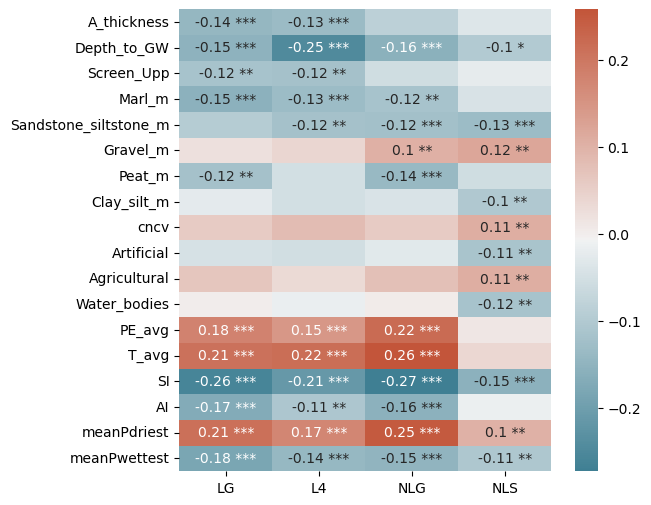

In [14]:
palette = sns.diverging_palette(220, 20, as_cmap=True)

fig, ax = plt.subplots(figsize=(6,6)) 
heatmap = sns.heatmap(corrs_selected, annot = annot,  
                      fmt = '', cmap = palette, ax= ax)

plt.savefig(os.path.join(os.getcwd(), 'output', 'paper_figures', 'figure_03.pdf'),
            bbox_inches="tight", dpi=300)

## Run Random Forest and compute SHAP values

In [15]:
def calculate_and_plot_shap_values(model, x, structure):

    # calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = shap.TreeExplainer(model).shap_values(x)
    
    # create a DataFrame and sort descending
    shap_df = pd.DataFrame(list(zip(x.columns, np.abs(shap_values).mean(0))), 
                           columns=['descriptor', 'mean_abs_shap'])
    shap_df = shap_df.sort_values(by=['mean_abs_shap'], ascending=False, ignore_index=True)
        
    top_10_descriptors = shap_df['descriptor'][0:10].to_list()

    indices = []
    for descriptor in top_10_descriptors:
        index = x.columns.to_list().index(descriptor)
        indices.append(index)
    
    feature_names = [a + ": " + str(b) for a,b in zip(x.columns, np.abs(shap_values).mean(0).round(3))]
    
    # Summary plot
    fig, ax = plt.subplots(1, 1, dpi=300)
    shap.summary_plot(shap_values, x, max_display=10, feature_names=feature_names, 
                      sort=True, cmap=palette)
    fig.savefig(os.path.join(os.getcwd(), 'output', 'paper_figures', 'figure_shap_{}.pdf'.format(structure)),
                bbox_inches="tight", dpi=300)
    plt.close()
        
    # plot Partial dependance
    fig, axes = plt.subplots(2, 5, figsize=(10, 4), constrained_layout=True)
    display = PartialDependenceDisplay.from_estimator(model, x, top_10_descriptors, ax=axes, 
                                                      line_kw={"color": "black"}, random_state=0)

    for num, axis in enumerate(axes.flatten()):
        axis.set_xlabel(top_10_descriptors[num])
        axis.tick_params(axis='both', which='major')

    fig.savefig(os.path.join(os.getcwd(), 'output', 'paper_figures', 'figure_part_dep_{}.pdf'.format(structure)),
                dpi=300)
    plt.close()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


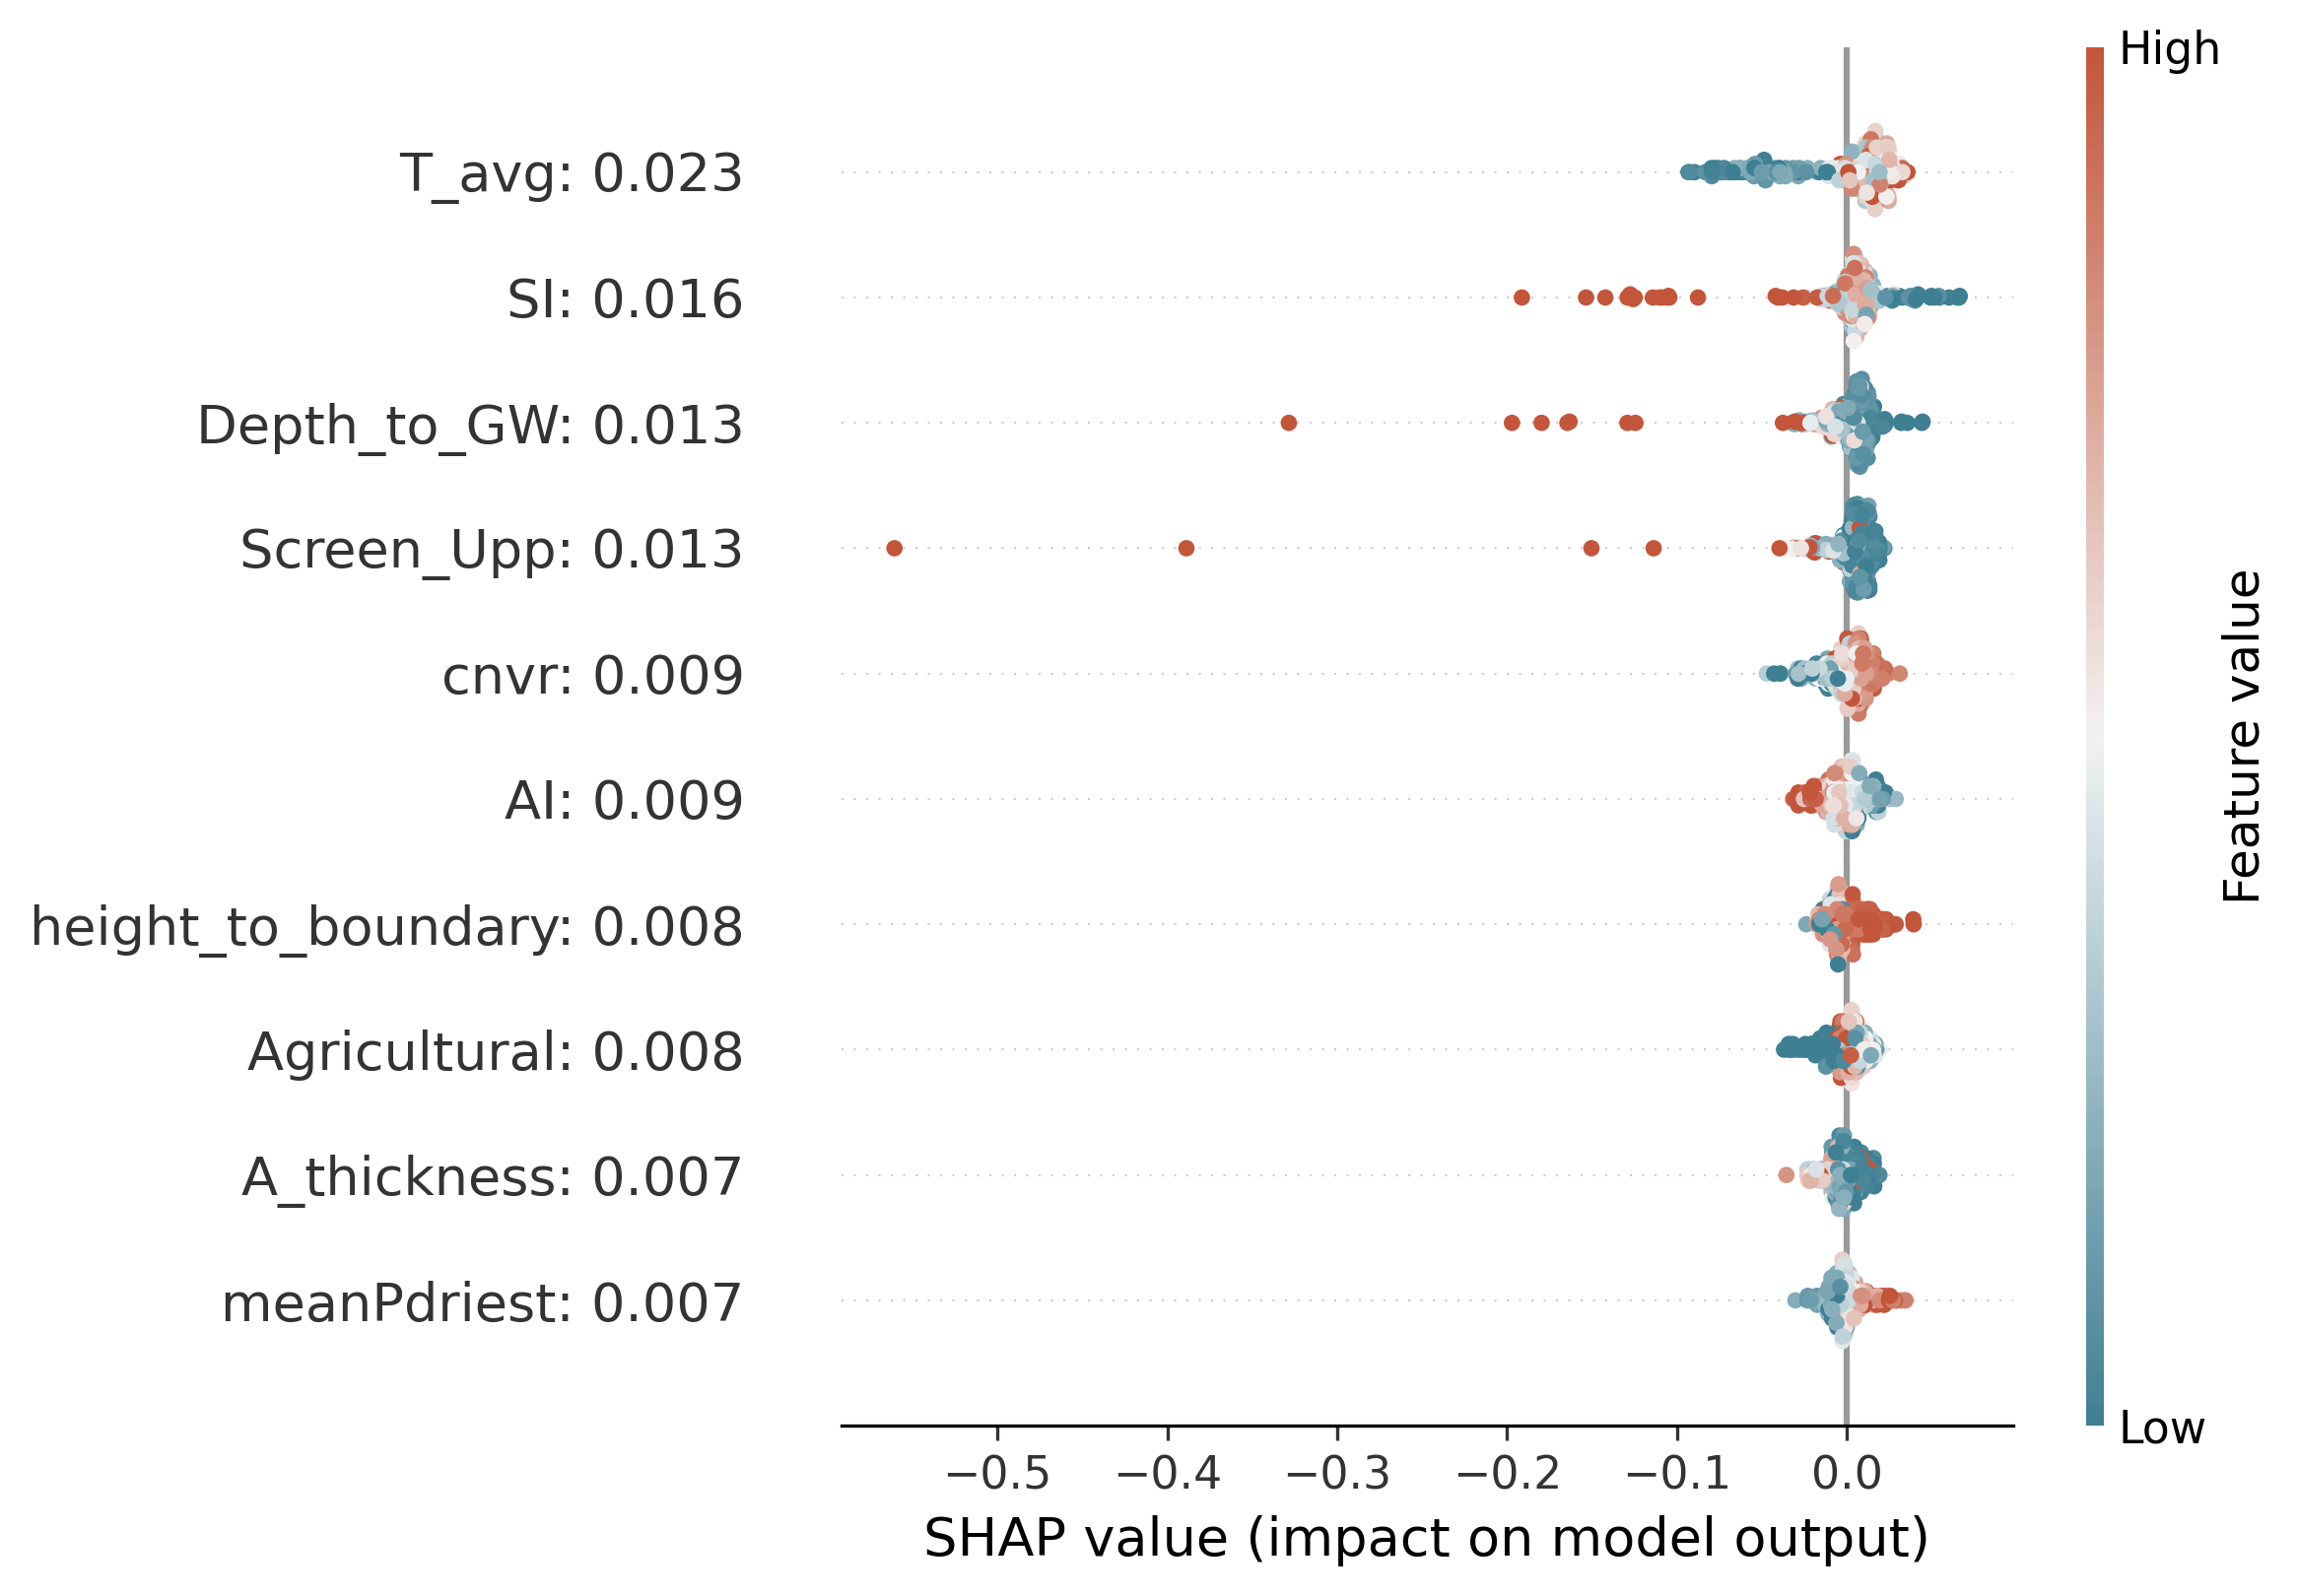

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


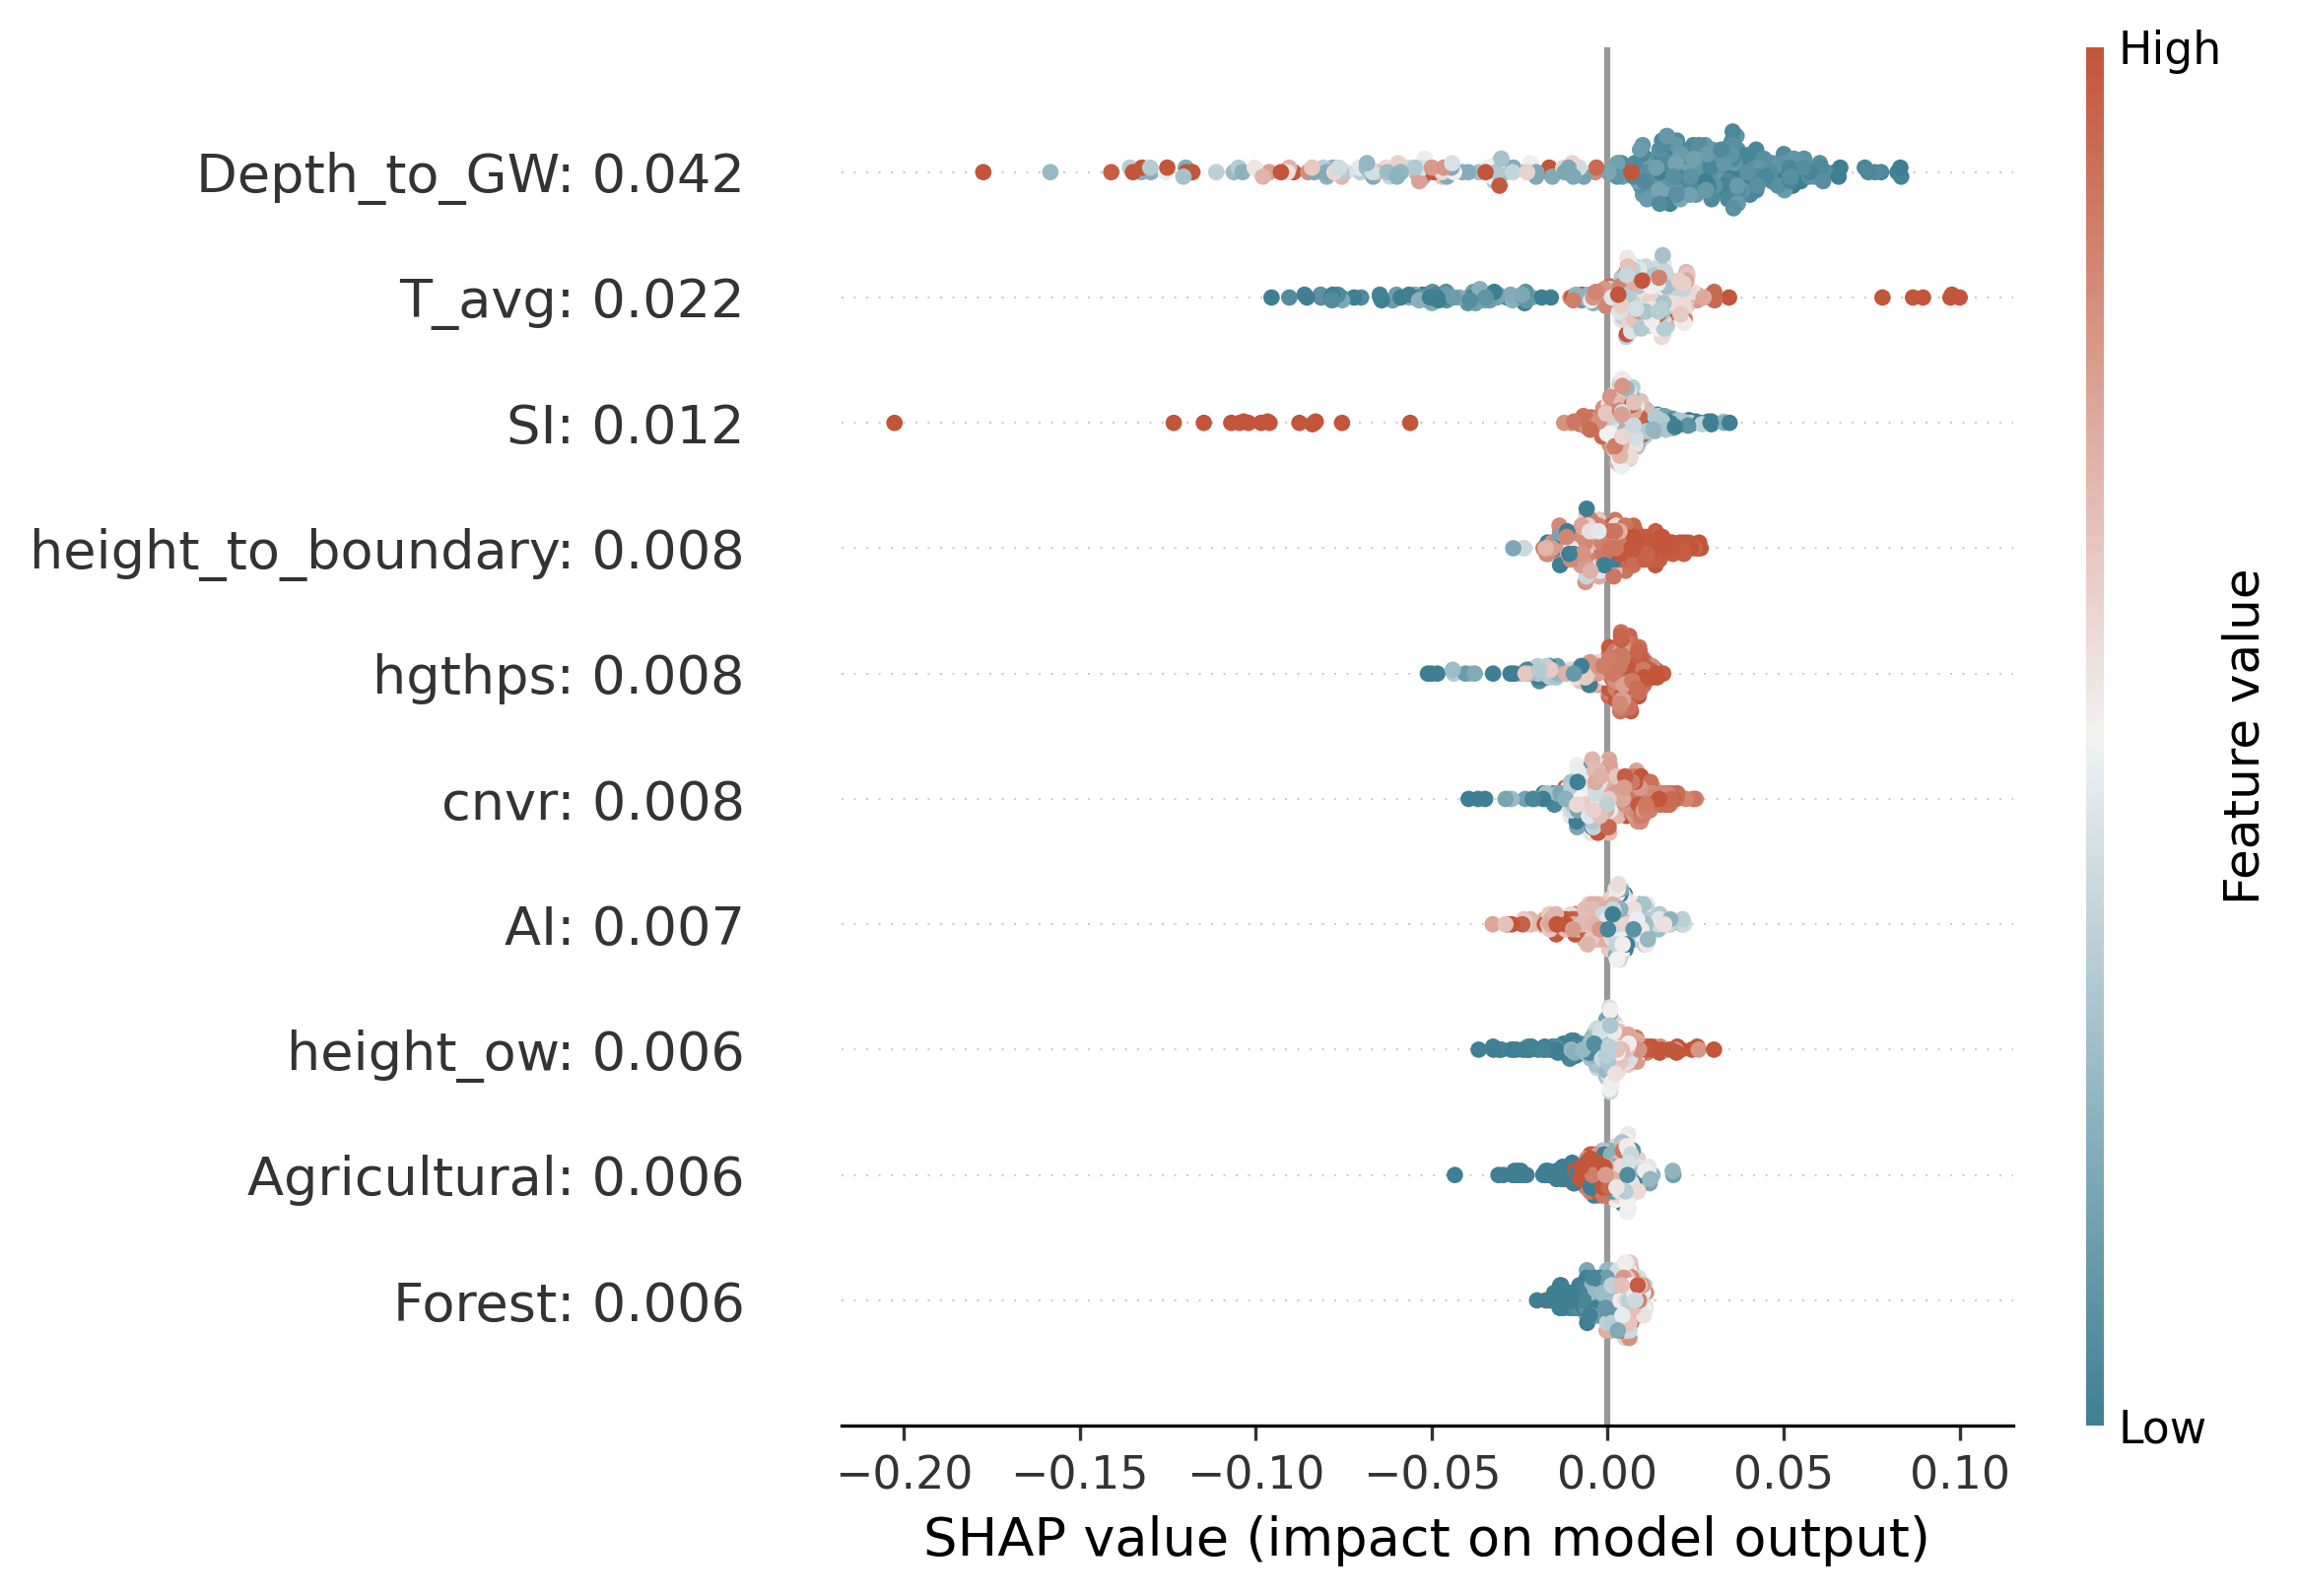

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


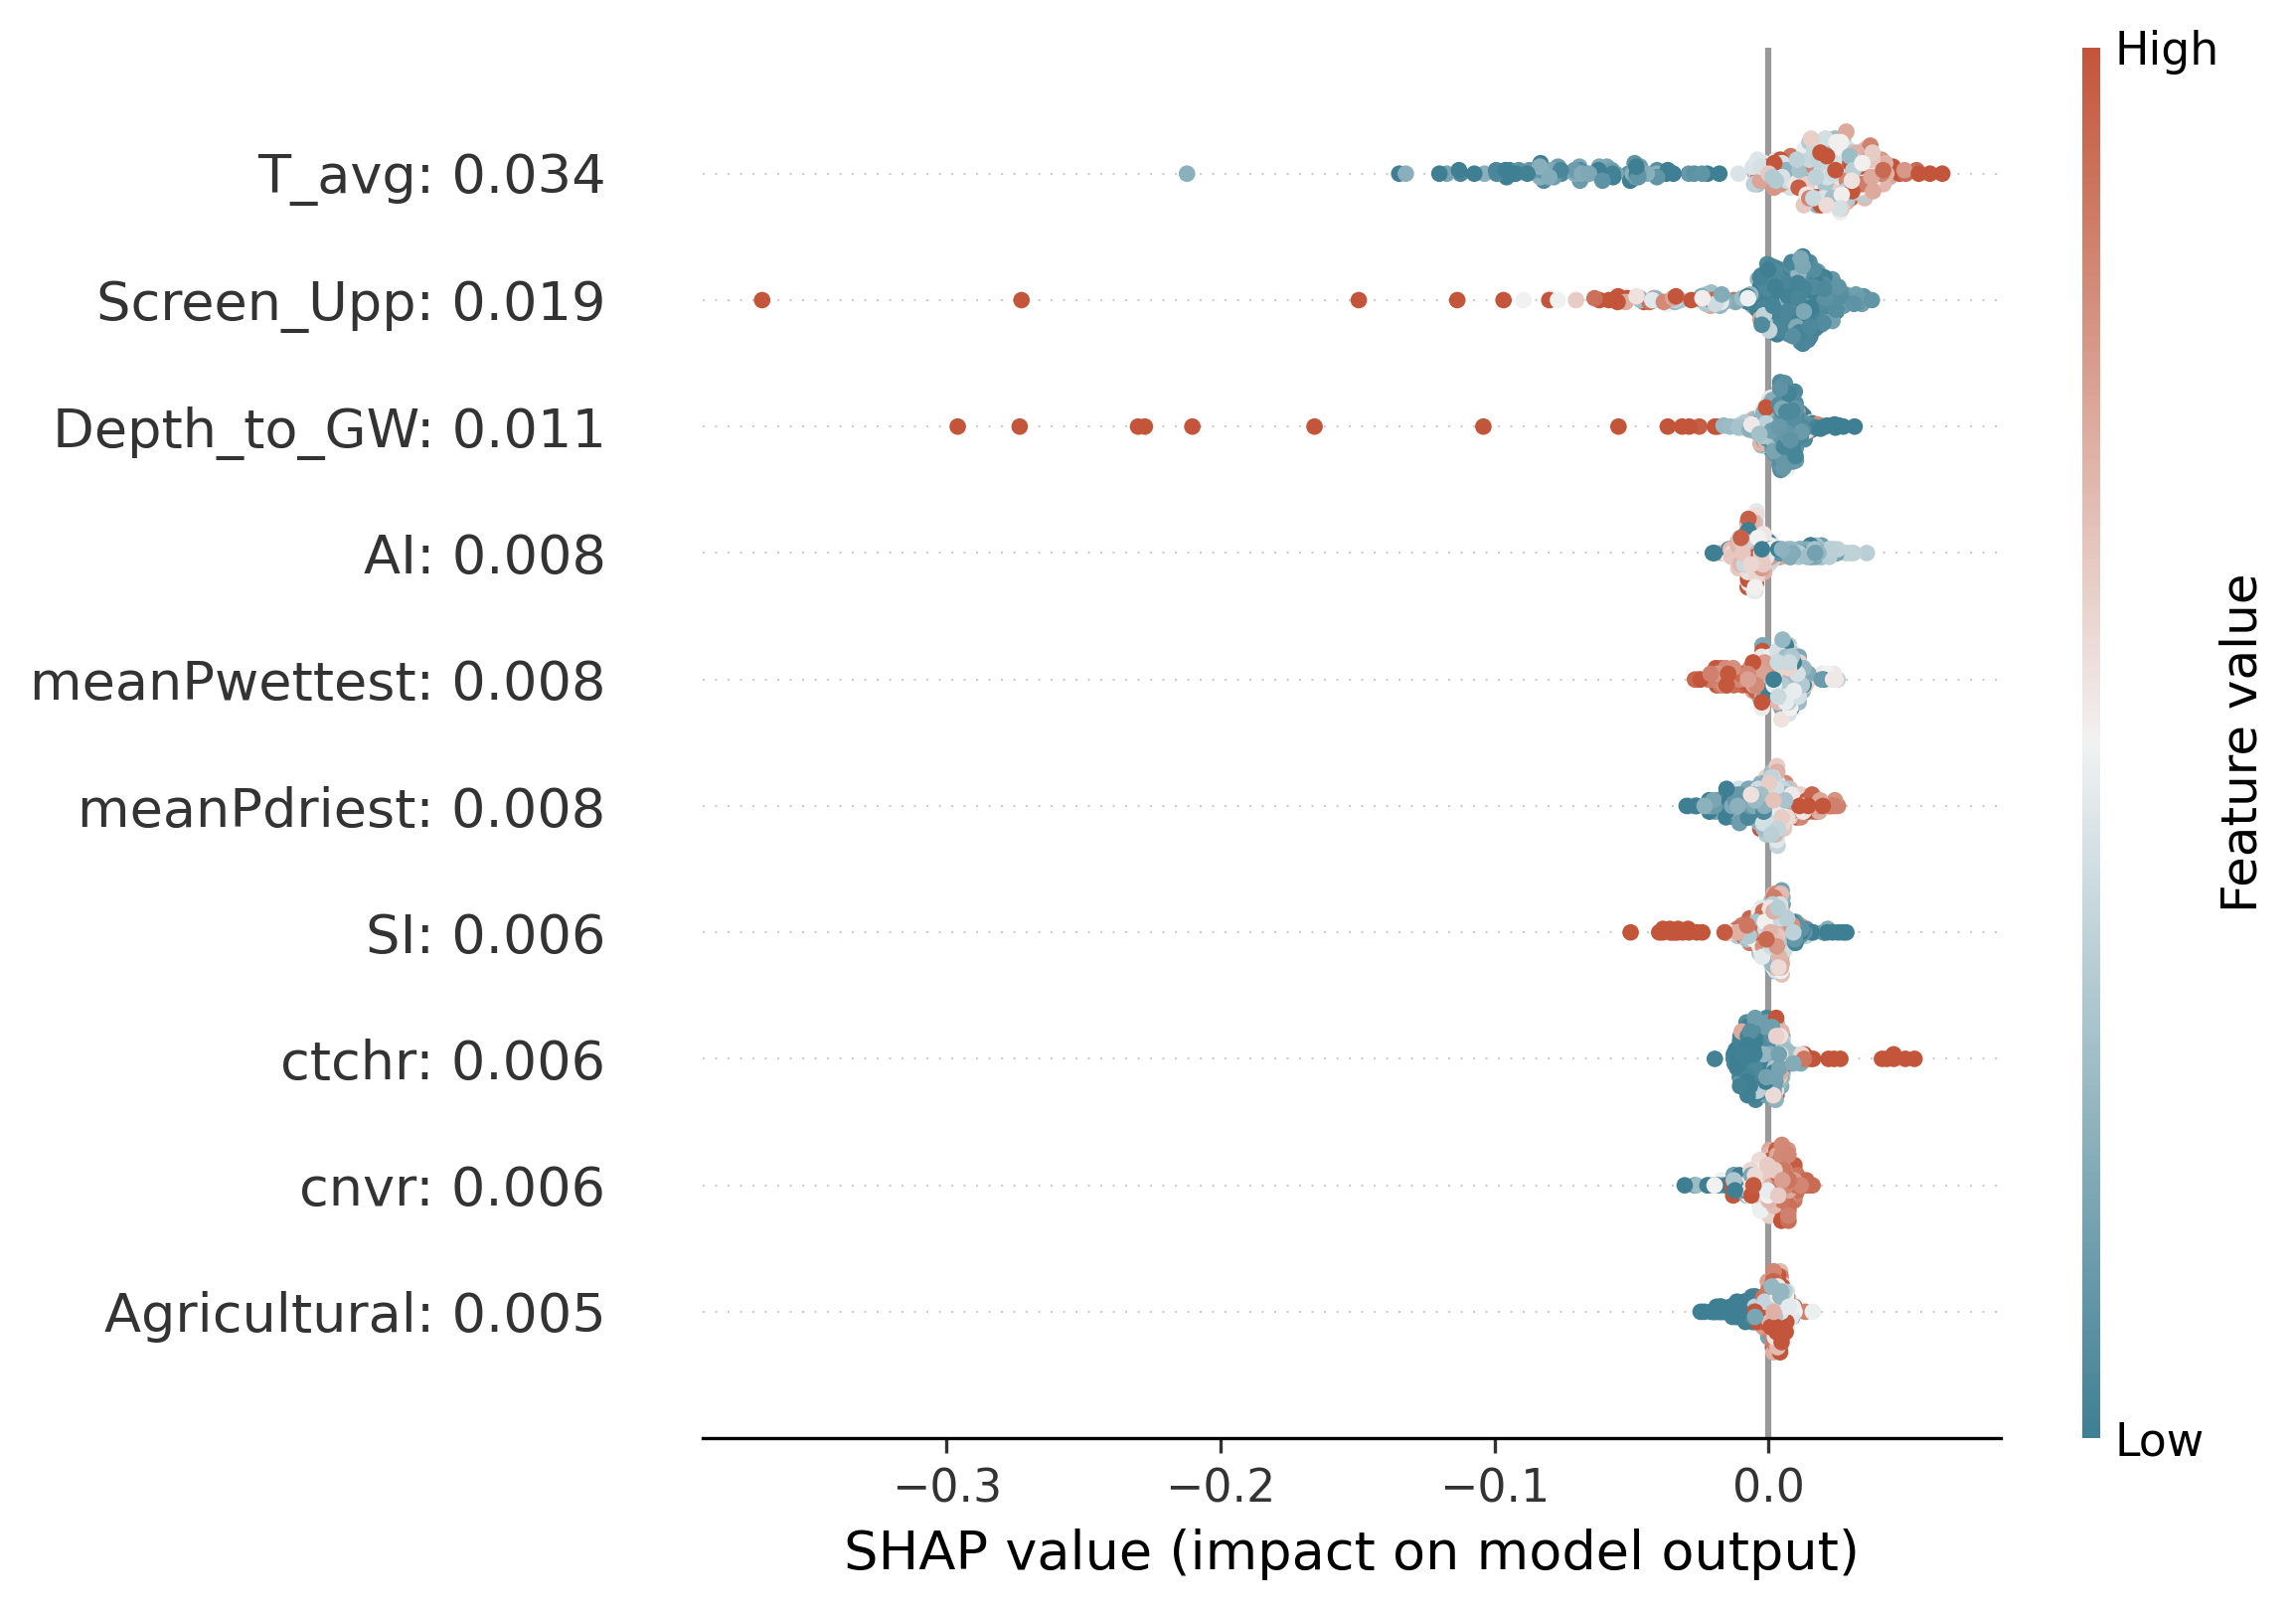

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


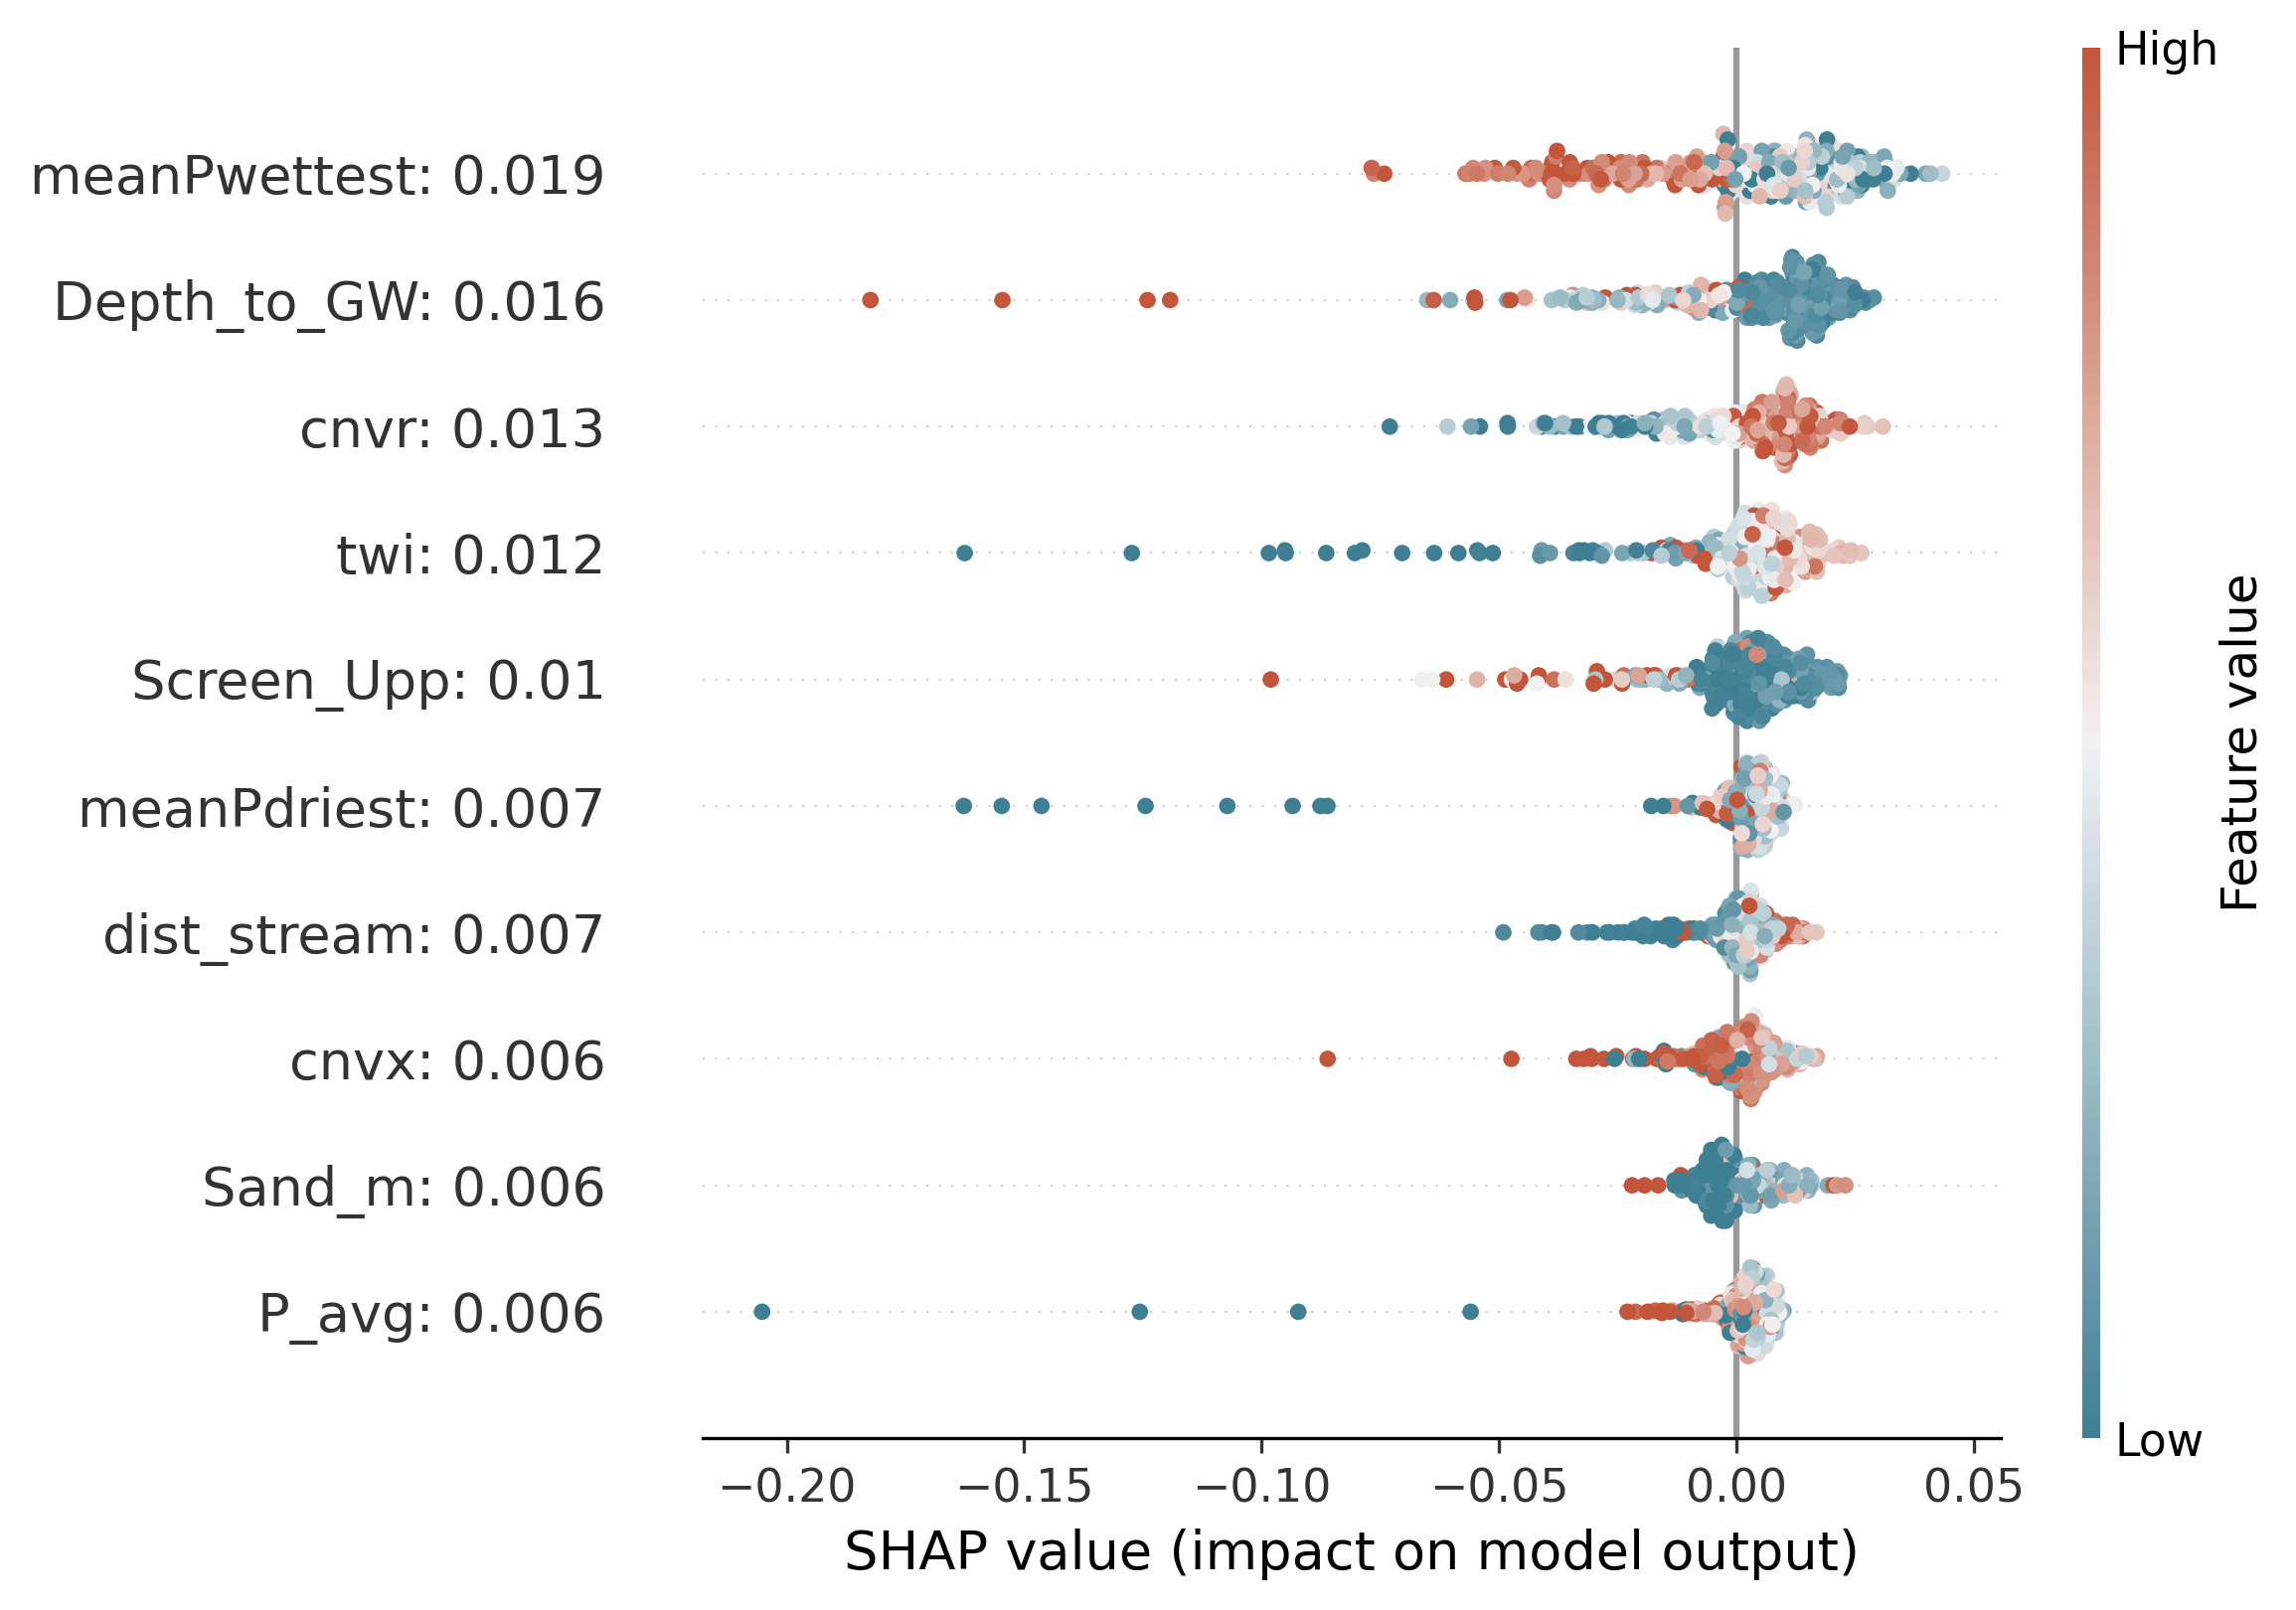

In [16]:
fits = {}

for structure in structures:
    # Prepare x and y values
    x = environmental_variables.dropna(how = 'any')
    df_nse = metrics.loc[(slice(None), structure), "NSE_c"]
    df_nse.index = df_nse.index.droplevel(1)
    y = df_nse.loc[x.index]
    
    # Create the random forest model
    model = RandomForestRegressor(random_state = 0)
    model.fit(x, y)
    fits[structure] = model.score(x, y)
    # Compute SHAP values and make plots
    calculate_and_plot_shap_values(model, x, structure)     

In [17]:
fits

{'LG': 0.850418814624938,
 'L4': 0.8921129429917177,
 'NLG': 0.859970271516985,
 'NLS': 0.8735795782227063}

## Retrieve model parameters

In [18]:
threshold = 0.65

metrics = pd.read_csv(os.path.join(os.getcwd(), 'output', 'metrics.csv' ), index_col=[0,1])  # Reload just to be sure

passed = metrics.loc[(metrics.loc[:, "NSE_c"] > threshold) &
                     (metrics.loc[:, "KGE_c"] > threshold)].index
passed = pd.DataFrame(index=passed, columns=["value"], data=1)
passed_cal = passed.unstack().fillna(0.0)
passed_cal.loc[passed_cal.astype(bool).all(axis=1)].index
models_with_good_fit = passed_cal.loc[passed_cal.astype(bool).all(axis=1)].index
print("Number of wells where all models have a good fit is:", models_with_good_fit.size)
models_with_good_fit

Number of wells where all models have a good fit is: 36


Index(['LV|9667', 'LV|9732', 'LV|19035', 'LV|690', 'LV|9579', 'LV|9561',
       'LV|2772', 'LV|9611', 'EE|10058', 'EE|4273', 'EE|7393', 'EE|7595',
       'EE|7574', 'EE|7576', 'EE|7575', 'EE|7582', 'EE|1894', 'EE|1895',
       'EE|1896', 'EE|1898', 'EE|3652', 'EE|12772', 'EE|12676', 'EE|13714',
       'EE|8730', 'EE|259', 'EE|1143', 'EE|13096', 'LT|296', 'LT|297',
       'LT|252', 'LT|282', 'LT|69', 'LT|72', 'LT|76', 'LT|77'],
      dtype='object')

In [19]:
parameters = pd.read_csv(os.path.join(os.getcwd(), 'output', 'params.csv'), index_col=[0, 1], header=0)
parameters = parameters.loc[models_with_good_fit]
parameters.head()

rch_A     rch_n       rch_a
LV|9667 LG    0.494946  1.233231  110.009757
        L4    0.491913  1.234627  109.026899
        NLG  14.751938  0.369790   18.889720
        NLS  12.910663  0.464644   20.932089
LV|9732 LG    0.701170  1.232465  213.652372

## Compute correlation between parameters and environmental variables

In [20]:
structures = ['LG', 'L4', 'NLG', 'NLS']

corrs_params = {}
sigs_params = {}

for structure in structures:
    df = parameters.loc[(slice(None), structure), :]
    df.index = df.index.droplevel(1)
    
    rho = {}
    pval = {}

    for p in df.columns:
        rho[p] = environmental_variables.loc[df.index].corrwith(df.loc[:, p], method="spearman")
        pval[p] = environmental_variables.loc[df.index].corrwith(df.loc[:, p], method=lambda x, y: spearmanr(x, y)[1])

    corrs_params[structure] = pd.concat(rho, axis=1)
    sigs_params[structure] = pd.concat(pval, axis=1)
    
corrs_params = pd.concat(corrs_params, axis=1)
sigs_params = pd.concat(sigs_params, axis=1)

corrs_params.head()

LG                            L4                      \
                rch_A     rch_n     rch_a     rch_A     rch_n     rch_a   
A_thickness -0.111158 -0.096615  0.066193 -0.216966 -0.029921 -0.099958   
Depth_to_GW  0.489874  0.460317  0.542967  0.340449  0.392994  0.412151   
Screen_Upp   0.262703  0.224803  0.445175  0.180637  0.176053  0.314969   
Dolomite_m  -0.179360 -0.074579 -0.134366 -0.180798  0.028147 -0.255377   
Limestone_m -0.365172 -0.156999 -0.107813 -0.366662 -0.095889 -0.147062   

                  NLG                           NLS                      
                rch_A     rch_n     rch_a     rch_A     rch_n     rch_a  
A_thickness -0.522190  0.173840 -0.073046 -0.509486 -0.077560  0.158964  
Depth_to_GW  0.081007  0.450465  0.487137  0.189929  0.536398  0.066229  
Screen_Upp  -0.211049  0.532437  0.394132 -0.200046  0.346298  0.375029  
Dolomite_m  -0.250241  0.069237 -0.109712 -0.281059 -0.075607  0.058965  
Limestone_m -0.606135 -0.098870 -0.128183 -0.553471 -0.120233  0.225562

In [21]:
sigs_params.head()

LG                            L4                      \
                rch_A     rch_n     rch_a     rch_A     rch_n     rch_a   
A_thickness  0.537998  0.592743  0.714372  0.225195  0.868716  0.579945   
Depth_to_GW  0.008143  0.013706  0.002830  0.076272  0.038566  0.029303   
Screen_Upp   0.133350  0.201171  0.008334  0.306624  0.319268  0.069621   
Dolomite_m   0.317918  0.679987  0.455968  0.313988  0.876436  0.151465   
Limestone_m  0.036650  0.382911  0.550373  0.035833  0.595540  0.414106   

                  NLG                           NLS                      
                rch_A     rch_n     rch_a     rch_A     rch_n     rch_a  
A_thickness  0.001826  0.333282  0.686227  0.002459  0.667913  0.376910  
Depth_to_GW  0.681967  0.016149  0.008561  0.333025  0.003256  0.737746  
Screen_Upp   0.230863  0.001189  0.021086  0.256652  0.044827  0.028856  
Dolomite_m   0.160152  0.701821  0.543331  0.113095  0.675816  0.744462  
Limestone_m  0.000185  0.584099  0.477145  0.000835  0.505104  0.206901

## Plots the parameter correlation

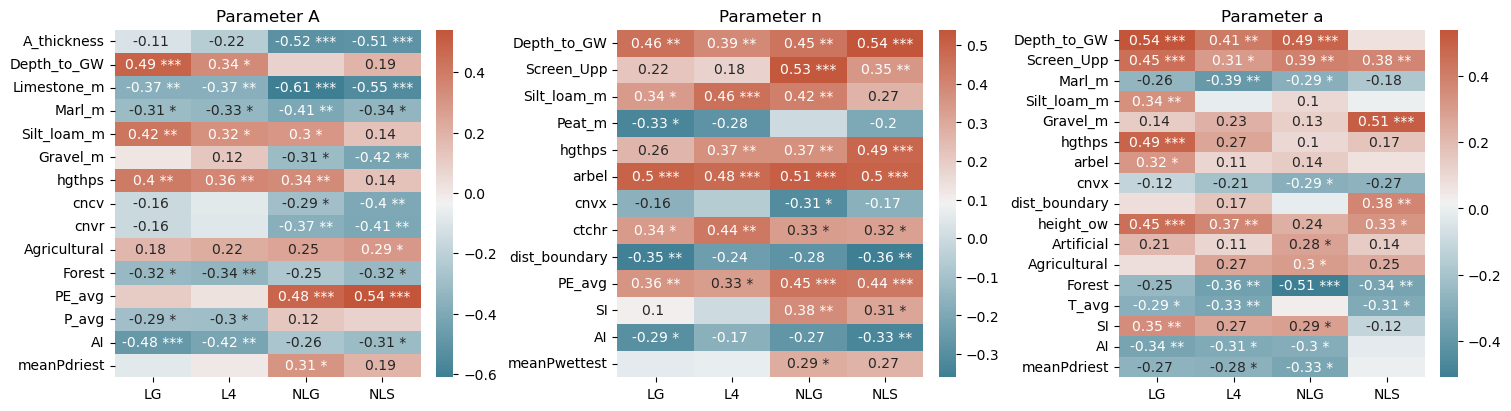

In [22]:
fig, axes = plt.subplots(1,3, figsize=(15, 4), constrained_layout=True)

for i, param in enumerate(corrs_params.columns.get_level_values(1).unique()):
    
    corrs = corrs_params.loc[:, (slice(None), param)]
    corrs.columns = corrs.columns.droplevel(1)
    sigs = sigs_params.loc[:, (slice(None), param)]
    sigs.columns = sigs.columns.droplevel(1)
    
    selected = corrs.index[((corrs.abs() >= 0.1) & (sigs.abs() <= 0.1)).any(axis=1)]
    annot = value_on_correl_plot(corrs.loc[selected], sigs.loc[selected], threshold=0.1)
    
    heatmap = sns.heatmap(corrs.loc[selected].round(2), annot=annot,
                          fmt = '', cmap = palette, ax=axes[i])
    axes[i].set_xticklabels(corrs_params.columns.get_level_values(0).unique())
    axes[i].set_title("Parameter {}".format(param.split("_")[1]))
    axes[i].set_xlabel("")
    
plt.savefig(os.path.join(os.getcwd(), 'output', 'paper_figures', 'figure_06.pdf'),
            bbox_inches="tight", dpi=300)